In [ ]:
import os
from google.colab import drive

drive.mount("/content/MyDrive")

Mounted at /content/MyDrive


In [4]:
!pip install resampy
!pip install librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.5 MB/s eta 0:00:00


##Importing Libraries

In [9]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
import pandas as pd
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.models import load_model
import joblib
import scipy.io.wavfile

In [ ]:
emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

feelings = []
audio = []

for k in range(1,10):
    c = os.listdir(f"RAVDESS_Dataset/Actor_0{k}")
    audio.extend(c)
    gen = "female" if k % 2 == 0 else "male"
    for i in c:
        em = i.split("-")[2]
        feelings.append(f"{gen}_{emotion_mapping[em]}")

for k in range(10,25):
    c = os.listdir(f"RAVDESS_Dataset/Actor_{k}")
    audio.extend(c)
    gen = "female" if k % 2 == 0 else "male"
    for i in c:
        em = i.split("-")[2]
        feelings.append(f"{gen}_{emotion_mapping[em]}")

In [ ]:
feelings[:5]

['male_angry', 'male_fearful', 'male_sad', 'male_calm', 'male_neutral']

## Plotting the audio file's waveform and its spectrogram

In [ ]:
data, sampling_rate = librosa.load('RAVDESS_Dataset/Actor_01/03-01-01-01-01-02-01.wav')

In [ ]:
sampling_rate

22050

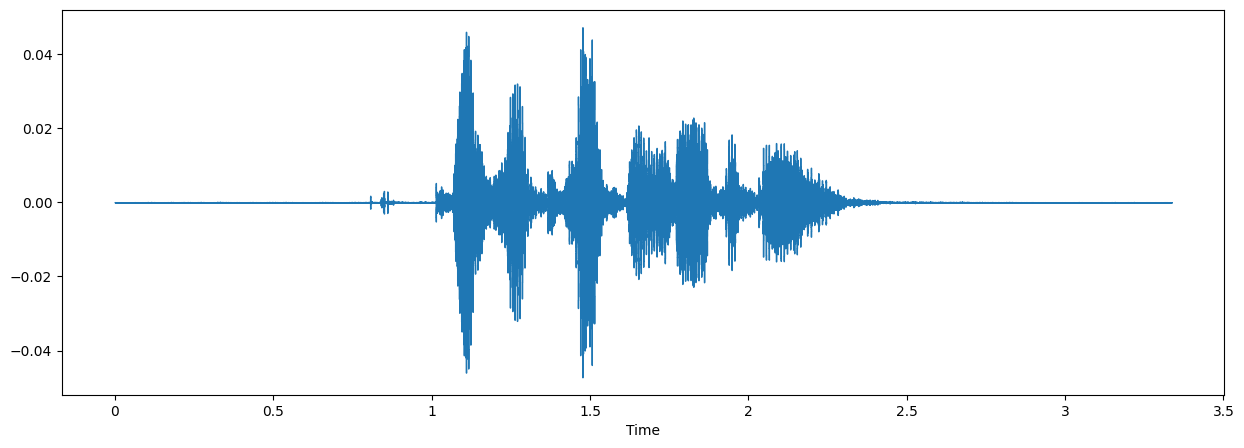

In [ ]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

<ipython-input-13-aac0d9036a4d>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('/content/MyDrive/MyDrive/RAVDESS_Dataset/Actor_01/03-01-01-01-01-02-01.wav')
<ipython-input-13-aac0d9036a4d>:26: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


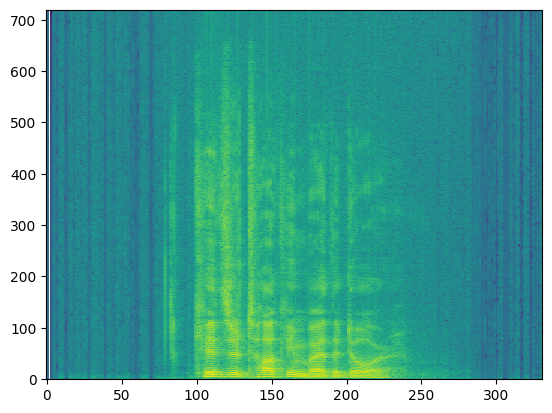

In [ ]:
sr,x = scipy.io.wavfile.read('RAVDESS_Dataset/Actor_01/03-01-01-01-01-02-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhance its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.

In [17]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

In [ ]:
path = 'RAVDESS_Dataset/Actor_02/03-01-01-01-01-01-02.wav'
data, sample_rate = librosa.load(path)

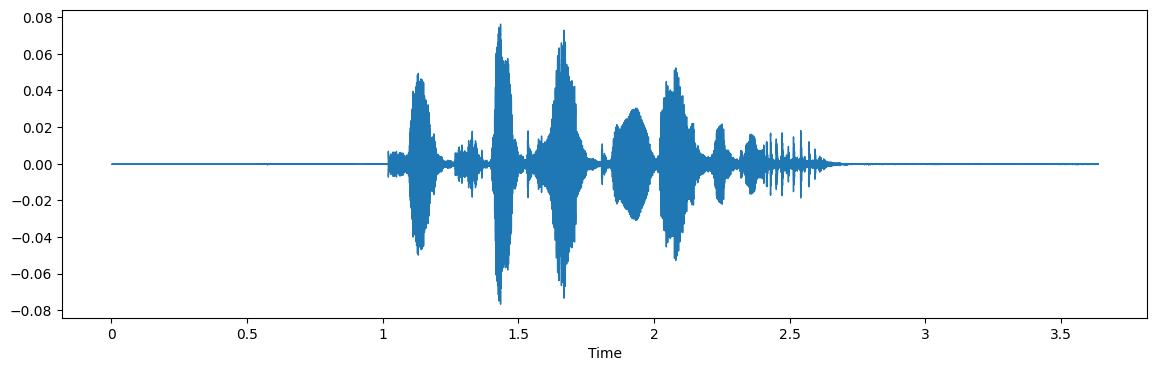

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

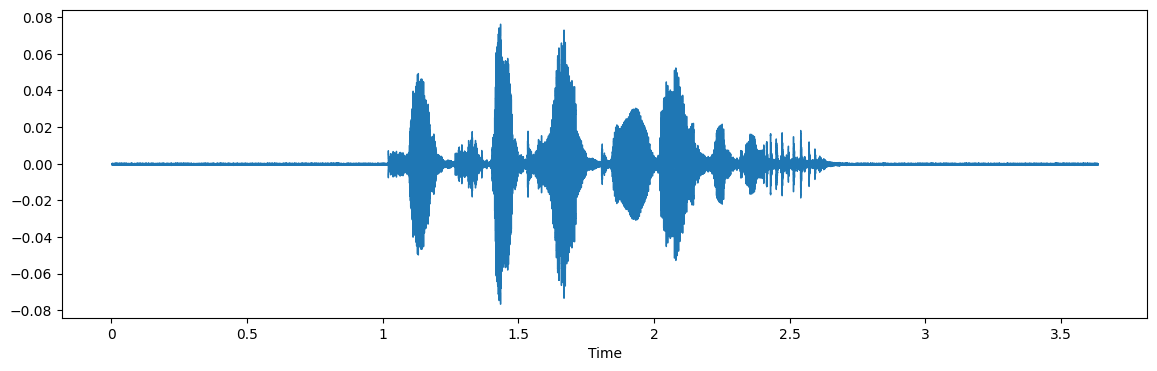

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

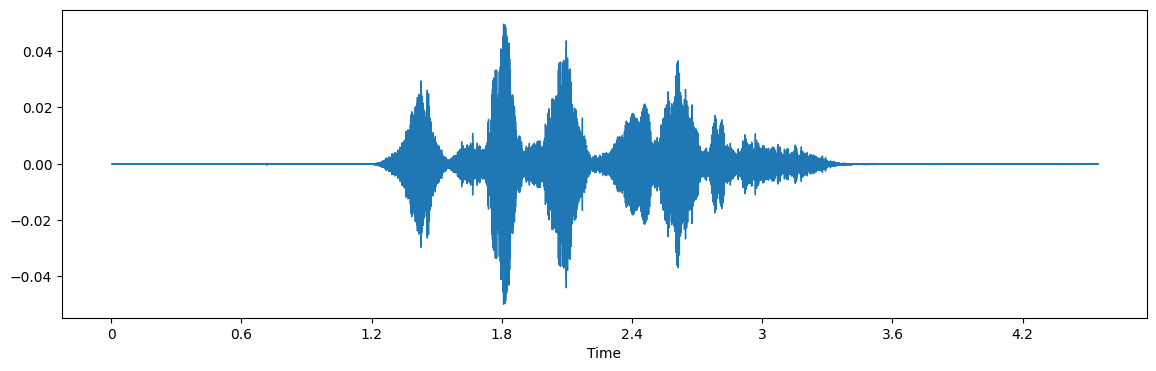

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

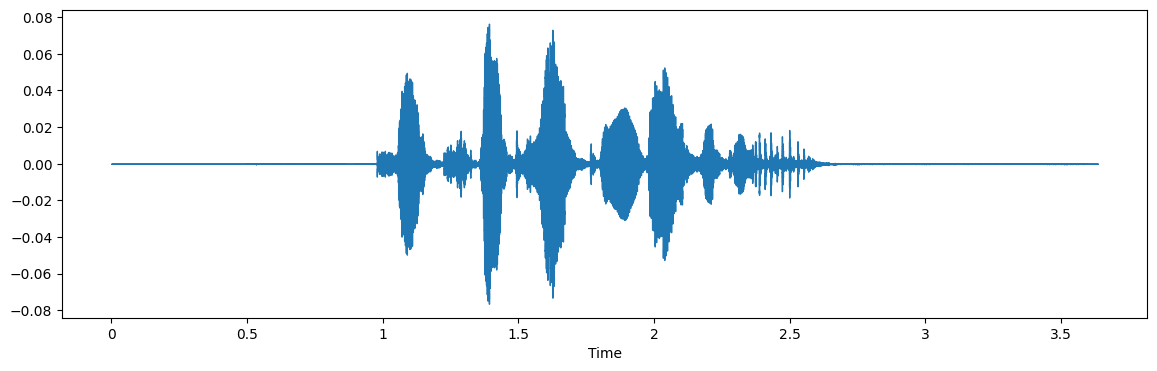

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I referenced an excellent blog on audio signal feature extraction and clustering written by Akash Mallik, which can be found on Medium : [Audio signal feature extraction and clustering](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225)


As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting the MFCC feature

In [18]:
def extract_features(data, sample_rate):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return np.array(mfcc)

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with shift
    shift_data = shift(data)
    res3 = extract_features(shift_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with stretching
    new_data = stretch(data)
    res4 = extract_features(new_data, sample_rate)
    result = np.vstack((result, res4)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
for aud, label in zip(audio,feelings):
    ac = aud.split("-")[-1].split(".")[0]
    feature = get_features(f'RAVDESS_Dataset/Actor_{ac}'+'/'+ aud)
    for ele in feature:
        X.append(ele)
        # appending emotion 4 times as we have made 4 augmentation techniques on each audio file.
        Y.append(label)

In [ ]:
Y[:5]

['male_angry', 'male_angry', 'male_angry', 'male_angry', 'male_fearful']

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-444.204468,65.577614,-9.480271,19.433031,-2.393804,-4.576007,-6.691092,-2.386163,-19.320045,-7.458088,...,-7.401238,-1.130604,-7.198738,-5.098989,-2.847116,-9.578761,-2.955848,-6.167402,-5.261926,male_angry
1,-305.207089,29.354237,4.760844,8.680641,-0.946280,-4.129570,-1.518199,-2.719441,-9.475303,-5.824788,...,-3.398449,-2.185311,-3.529007,-3.515780,-2.396716,-4.341717,-3.709331,-2.614516,-4.122621,male_angry
2,-305.207089,29.354237,4.760844,8.680641,-0.946280,-4.129570,-1.518199,-2.719441,-9.475303,-5.824788,...,-3.398449,-2.185311,-3.529007,-3.515780,-2.396716,-4.341717,-3.709331,-2.614516,-4.122621,male_angry
3,-443.576874,65.165268,-9.018850,19.050684,-2.258634,-4.516479,-6.781244,-2.463115,-19.069128,-7.436035,...,-7.440837,-1.220531,-7.188084,-5.137364,-2.869482,-9.490922,-3.088090,-6.160025,-5.222818,male_angry
4,-526.167480,83.845795,-6.205264,22.149710,8.623187,-1.434714,-5.779510,-14.535985,-15.195954,-2.270834,...,-2.680221,-0.449240,-6.124558,0.261475,-0.338757,-4.711348,-5.393372,-0.717083,2.036049,male_fearful


In [ ]:
Features.value_counts('labels')

labels
female_angry        384
female_calm         384
female_disgust      384
female_fearful      384
female_happy        384
female_sad          384
female_surprised    384
male_angry          384
male_calm           384
male_disgust        384
male_fearful        384
male_happy          384
male_sad            384
male_surprised      384
female_neutral      192
male_neutral        192
Name: count, dtype: int64

* We have applied data augmentation and extracted the features for each audio files and saved them.

In [ ]:
Features = pd.read_csv("/content/features.csv")

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [ ]:
from sklearn.utils import shuffle
rnewdf = shuffle(Features)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
5108,-409.689484,50.930672,-24.175577,-15.165511,-1.531521,-18.833136,-22.195583,-20.374290,-22.893559,-1.824717,...,-18.674604,-7.745239,-10.692157,-10.050335,-15.627760,-8.587105,-6.115967,-3.275834,3.357937,female_happy
4205,-430.065356,26.654103,13.683221,3.317119,0.304644,-0.318559,-3.660503,-7.517803,-8.324434,-7.051188,...,-7.258438,-6.022260,-3.851232,-3.167873,-5.494746,-6.520183,-4.548318,-5.332779,-3.918349,female_surprised
3461,-279.284696,33.924295,-3.723966,6.614517,5.401308,-6.837772,-5.597264,-3.258842,-9.591803,-3.830815,...,-0.195614,-0.535085,-2.078271,-0.671821,-0.848513,-3.418130,-3.920452,-1.900411,-2.377584,male_happy
5311,-558.708923,67.750603,-4.199669,14.001829,9.341100,0.475402,-2.480241,-10.251335,-9.213098,-8.987862,...,-6.057377,-5.389161,1.015463,-6.067409,0.845496,-6.175589,-4.136829,-2.338804,-2.608393,male_sad
3434,-341.754728,42.583388,-5.122797,9.886415,7.119734,-5.636813,-1.188273,-0.315893,-5.809186,1.067790,...,-1.167079,1.099994,-0.506456,0.917878,2.464297,-0.583715,-1.832127,2.771055,-0.571150,male_happy
4681,-391.244414,17.919578,5.921471,5.963326,-2.242606,-2.348587,-5.845348,-8.877154,-6.948985,-6.585580,...,-2.416452,-4.782659,-1.042910,-4.760404,-5.544179,-2.033598,-3.618062,-6.377417,-3.620769,female_happy
25,-435.998466,27.392604,8.537152,10.286501,5.555239,-0.373027,-2.400343,-6.911271,-9.015230,-4.984053,...,-2.316471,-1.457405,-1.913679,-0.679396,-0.275947,-3.349192,-2.028630,-0.271915,-2.377754,male_neutral
5528,-609.887939,61.837933,-11.519303,4.964216,-13.302252,-8.474178,-17.473244,-16.919479,-8.386958,-7.709579,...,-0.560614,-9.602570,-6.414075,-2.519728,-9.910450,-3.976235,-6.537751,-6.724433,-5.628495,female_neutral
794,-243.418776,11.500023,-12.337702,-3.899445,-5.854181,-9.807839,-5.425992,-11.374957,-8.203980,-3.807734,...,-5.797971,1.184321,9.561442,9.018494,11.259658,7.981727,-0.290021,-3.545111,-2.547348,female_sad
3633,-418.326892,26.630067,6.198701,0.948450,-3.548064,-7.811751,-13.168519,-10.643094,-6.510003,-3.393095,...,-4.278951,-1.296480,-4.249337,-3.314454,-3.241590,-4.597328,-3.349222,-4.856687,-5.471342,female_sad


In [ ]:
X = rnewdf.iloc[: ,:-1].values
Y = rnewdf['labels'].values

In [ ]:
X.shape

(5760, 20)

In [ ]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4320, 20), (4320, 16), (1440, 20), (1440, 16))

In [ ]:
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4320, 20), (4320, 16), (1440, 20), (1440, 16))

In [ ]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)

In [ ]:
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((4320, 20, 1), (4320, 16), (1440, 20, 1), (1440, 16))

## Modelling

In [ ]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(20,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(64, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(64, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(32, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(16))
model.add(Activation('softmax'))

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.00002,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)
opt = keras.optimizers.RMSprop(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 20, 256)           1536      
                                                                 
 activation_14 (Activation)  (None, 20, 256)           0         
                                                                 
 conv1d_13 (Conv1D)          (None, 20, 128)           163968    
                                                                 
 activation_15 (Activation)  (None, 20, 128)           0         
                                                                 
 dropout_4 (Dropout)         (None, 20, 128)           0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 2, 128)            0         
 g1D)                                                            
                                                      

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=64, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
68/68 [==============================] - 7s 83ms/step - loss: 2.7711 - accuracy: 0.0678 - val_loss: 2.7706 - val_accuracy: 0.0618
Epoch 2/200
68/68 [==============================] - 4s 57ms/step - loss: 2.7693 - accuracy: 0.0692 - val_loss: 2.7687 - val_accuracy: 0.0618
Epoch 3/200
68/68 [==============================] - 4s 57ms/step - loss: 2.7667 - accuracy: 0.0750 - val_loss: 2.7663 - val_accuracy: 0.0639
Epoch 4/200
68/68 [==============================] - 6s 91ms/step - loss: 2.7633 - accuracy: 0.0789 - val_loss: 2.7629 - val_accuracy: 0.0764
Epoch 5/200
68/68 [==============================] - 4s 58ms/step - loss: 2.7582 - accuracy: 0.0852 - val_loss: 2.7579 - val_accuracy: 0.0896
Epoch 6/200
68/68 [==============================] - 4s 58ms/step - loss: 2.7509 - accuracy: 0.0933 - val_loss: 2.7506 - val_accuracy: 0.0917
Epoch 7/200
68/68 [==============================] - 5s 75ms/step - loss: 2.7408 - accuracy: 0.1016 - val_loss: 2.7403 - val_accuracy: 0.1000
Epoch 

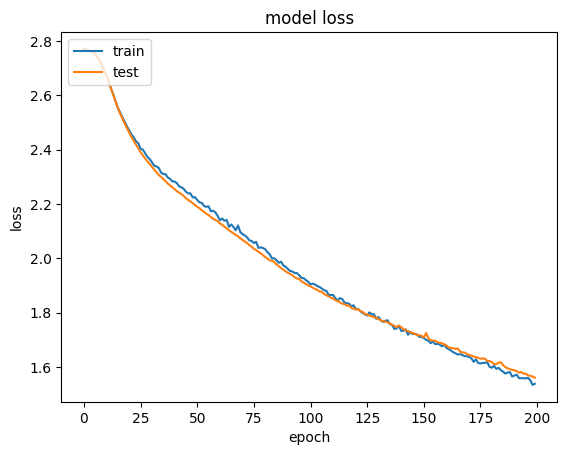

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_path = 'models/Emotion_Voice_Detection_Model.h5'
model.save(model_path)

In [ ]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.00002,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)
opt = keras.optimizers.RMSprop(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=64, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
68/68 [==============================] - 5s 62ms/step - loss: 1.5389 - accuracy: 0.4289 - val_loss: 1.5564 - val_accuracy: 0.4382
Epoch 2/200
68/68 [==============================] - 5s 73ms/step - loss: 1.5295 - accuracy: 0.4380 - val_loss: 1.5552 - val_accuracy: 0.4403
Epoch 3/200
68/68 [==============================] - 5s 73ms/step - loss: 1.5315 - accuracy: 0.4387 - val_loss: 1.5484 - val_accuracy: 0.4319
Epoch 4/200
68/68 [==============================] - 4s 58ms/step - loss: 1.5290 - accuracy: 0.4336 - val_loss: 1.5499 - val_accuracy: 0.4319
Epoch 5/200
68/68 [==============================] - 4s 58ms/step - loss: 1.5339 - accuracy: 0.4315 - val_loss: 1.5469 - val_accuracy: 0.4451
Epoch 6/200
68/68 [==============================] - 6s 89ms/step - loss: 1.5254 - accuracy: 0.4350 - val_loss: 1.5441 - val_accuracy: 0.4444
Epoch 7/200
68/68 [==============================] - 4s 57ms/step - loss: 1.5161 - accuracy: 0.4516 - val_loss: 1.5416 - val_accuracy: 0.4417
Epoch 

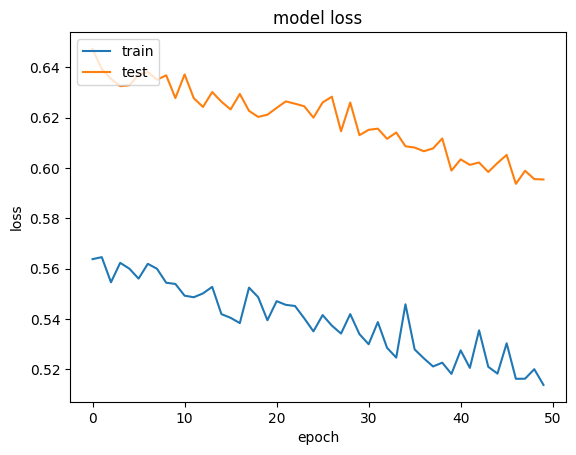

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)
opt = keras.optimizers.RMSprop(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=64, epochs=400, validation_data=(x_testcnn, y_test))

Epoch 1/400
68/68 [==============================] - 4s 65ms/step - loss: 0.8314 - accuracy: 0.6968 - val_loss: 0.9215 - val_accuracy: 0.6938
Epoch 2/400
68/68 [==============================] - 5s 69ms/step - loss: 0.8287 - accuracy: 0.6988 - val_loss: 0.9214 - val_accuracy: 0.6757
Epoch 3/400
68/68 [==============================] - 5s 76ms/step - loss: 0.8266 - accuracy: 0.6963 - val_loss: 0.9154 - val_accuracy: 0.6910
Epoch 4/400
68/68 [==============================] - 4s 56ms/step - loss: 0.8381 - accuracy: 0.6947 - val_loss: 0.9188 - val_accuracy: 0.6861
Epoch 5/400
68/68 [==============================] - 4s 57ms/step - loss: 0.8271 - accuracy: 0.6970 - val_loss: 0.9197 - val_accuracy: 0.6819
Epoch 6/400
68/68 [==============================] - 6s 92ms/step - loss: 0.8435 - accuracy: 0.6986 - val_loss: 0.9126 - val_accuracy: 0.6910
Epoch 7/400
68/68 [==============================] - 4s 58ms/step - loss: 0.8261 - accuracy: 0.7000 - val_loss: 0.9139 - val_accuracy: 0.6833
Epoch 

KeyboardInterrupt: 

In [ ]:
directory = 'models'
model_path = os.path.join(directory, 'Emotion_Voice_Detection_Model_final.h5')

if not os.path.exists(directory):
    os.makedirs(directory)

model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
score = model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 72.71%


## Predicting emotions on the test data

In [ ]:
preds = model.predict(x_testcnn,
                         batch_size=32,
                         verbose=1)

45/45 [==============================] - 3s 66ms/step


In [ ]:
preds.shape

(1440, 16)

In [ ]:
pred_labels = np.argmax(preds, axis=1)

original_labels = encoder.categories_[0]

predicted_labels = original_labels[pred_labels]

In [ ]:
print("Predicted labels: ", predicted_labels)

Predicted labels:  ['female_disgust' 'male_angry' 'female_happy' ... 'female_disgust'
 'male_angry' 'female_neutral']


In [ ]:
preddf = pd.DataFrame({'predictedvalues': predicted_labels})
preddf[:10]

,predictedvalues
0,female_disgust
1,male_angry
2,female_happy
3,female_surprised
4,male_calm
5,male_surprised
6,female_fearful
7,male_fearful
8,male_calm
9,male_sad


In [ ]:
actual_labels_indices = y_test.argmax(axis=1)
actual_labels = original_labels[actual_labels_indices]
actualdf = pd.DataFrame({'actualvalues': actual_labels})
actualdf[:10]

,actualvalues
0,female_disgust
1,male_angry
2,female_happy
3,female_surprised
4,male_calm
5,male_surprised
6,female_fearful
7,male_fearful
8,male_calm
9,male_sad


In [ ]:
finaldf = actualdf.join(preddf)

In [ ]:
finaldf[170:180]

,actualvalues,predictedvalues
170,male_disgust,male_disgust
171,male_happy,male_happy
172,male_surprised,male_surprised
173,male_neutral,male_calm
174,male_disgust,male_surprised
175,male_neutral,male_calm
176,male_fearful,male_fearful
177,female_sad,female_sad
178,female_surprised,female_surprised
179,male_neutral,male_neutral


In [ ]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,93
female_calm,99
female_disgust,111
female_fearful,95
female_happy,86
female_neutral,52
female_sad,101
female_surprised,92
male_angry,91


In [ ]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,92
female_calm,125
female_disgust,106
female_fearful,92
female_happy,80
female_neutral,42
female_sad,103
female_surprised,95
male_angry,86


In [ ]:
folder_name = 'preprocessing_objects'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

joblib.dump(encoder, os.path.join(folder_name, 'onehot_encoder.pkl'))

joblib.dump(scaler, os.path.join(folder_name, 'robust_scaler.pkl'))

['preprocessing_objects/robust_scaler.pkl']

In [ ]:
folder_name = 'preprocessing_objects'

# Load the OneHotEncoder
encoder = joblib.load(os.path.join(folder_name, 'onehot_encoder.pkl'))

# Load the RobustScaler
scaler = joblib.load(os.path.join(folder_name, 'robust_scaler.pkl'))

## Live Demo

#### The file 'output10.wav' in the following cell is the file that was recorded live


In [11]:
model = load_model('model/Emotion_Voice_Detection_Model_final.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
def predict_label(file_path):
    # Load the audio file
    data, sample_rate = librosa.load(file_path)

    # Extract features from the new audio file
    features = extract_features(data, sample_rate)

    # Standardize the features
    features = scaler.transform([features])

    # Reshape to fit the model input
    features = np.expand_dims(features, axis=2)

    # Make prediction
    preds = model.predict(features, verbose=1)

    # Convert prediction to class index
    pred_label_index = np.argmax(preds, axis=1)

    # Convert class index to original label
    original_labels = encoder.categories_[0]

    # Map the class index to the original label
    predicted_label = original_labels[pred_label_index]

    return predicted_label

In [13]:
path = 'output10.wav'

In [14]:
Audio(path)

In [19]:
predicted_label = predict_label(path)
print("Predicted label: ", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
Predicted label:  ['male_disgust']
